In [2]:

%load_ext autoreload
%autoreload 2

In [3]:
import sys
from pathlib import Path

project_root = Path().resolve().parents[1]
sys.path.append(str(Path().resolve().parents[1]))

In [4]:
import os
import re

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from io import StringIO
import pandas as pd
import pickle
import igraph as ig
import torch

from grad.dataprep.util import create_pattern_dict, filter_dict
from grad.dataprep.util import *
from grad.dataprep.plotting_helpers import *
from grad.dataprep.generation import *
from util import *
from plotting_helpers import *

from simclr import * 
from augmentation import *

In [5]:
df_full = preprocess_df()

In [6]:
with_laund_networks = extract_laundering_networks_igraph(
    df_full,
    max_depth=4,
    max_networks=2000,
    collapse_threshold=10
) 

Laundering network from 0: 2 nodes, 2 transactions, 2 collapsed hubs
Laundering network from 2: 229 nodes, 2502 transactions, 32 collapsed hubs
Laundering network from 3: 91455 nodes, 1448680 transactions, 5384 collapsed hubs
Laundering network from 10: 178 nodes, 1672 transactions, 23 collapsed hubs
Laundering network from 26: 3 nodes, 6 transactions, 2 collapsed hubs
Laundering network from 3993: 227 nodes, 2618 transactions, 19 collapsed hubs
Laundering network from 4720: 551 nodes, 6213 transactions, 76 collapsed hubs
Laundering network from 5487: 613 nodes, 6563 transactions, 67 collapsed hubs
Laundering network from 1984: 1014 nodes, 12045 transactions, 107 collapsed hubs
Laundering network from 42: 116 nodes, 990 transactions, 13 collapsed hubs
Laundering network from 5555: 6 nodes, 11 transactions, 2 collapsed hubs
Laundering network from 3523: 228 nodes, 2442 transactions, 26 collapsed hubs
Laundering network from 6017: 102 nodes, 946 transactions, 12 collapsed hubs
Laundering

In [7]:
with_laund_networks[5]

{'start_node': 3993,
 'nodes': {29,
  1224,
  1650,
  1969,
  2078,
  2236,
  2285,
  2415,
  3429,
  3911,
  3993,
  4055,
  4058,
  4294,
  5431,
  7262,
  7653,
  7711,
  8126,
  9097,
  9387,
  9563,
  10742,
  12092,
  12852,
  13171,
  13181,
  14476,
  14700,
  14713,
  15149,
  15169,
  15308,
  15962,
  16830,
  17106,
  18132,
  19410,
  19426,
  21102,
  21138,
  21526,
  23023,
  23978,
  24410,
  25669,
  25929,
  26328,
  26983,
  27186,
  27381,
  27715,
  28334,
  29476,
  29518,
  34097,
  34367,
  34804,
  35454,
  37022,
  37977,
  38277,
  39037,
  40389,
  40439,
  41240,
  41302,
  41354,
  41602,
  43944,
  43951,
  44177,
  44935,
  45428,
  45628,
  45759,
  46254,
  48937,
  49343,
  49620,
  49685,
  49686,
  51828,
  52991,
  54503,
  54504,
  55199,
  55338,
  56274,
  56275,
  59429,
  64487,
  65092,
  66232,
  66766,
  67571,
  67974,
  68249,
  69143,
  69147,
  69323,
  69453,
  72155,
  73798,
  73898,
  75485,
  75912,
  78724,
  80003,
  80157,
  81

In [8]:
# for network in with_laund_networks:
#     plot_graph_from_dict_igraph(network, show=True, save_path= f"network_{with_laund_networks.index(network)}.png")

In [9]:
from collections import deque
import igraph as ig
import random

def extract_non_laundering_networks_igraph(
    df,
    max_depth=5,
    max_networks=10,
    collapse_threshold=10,
    min_size=10,
    random_seed=42
):
    """
    Extract non-laundering networks that contain NO laundering nodes.
    Uses igraph for fast traversal.
    Size is unconstrained except for a minimum cutoff.
    Returns a list of dictionaries (not graphs).
    """

    random.seed(random_seed)

    # --- Build full graph ---
    g = ig.Graph.DataFrame(
        df[["From_Account_int", "To_Account_int"]],
        directed=True,
        use_vids=True
    )

    # --- Identify laundering nodes ---
    laundering_nodes = set(
        df.loc[df["Is Laundering"] == 1, "From_Account_int"]
    ).union(
        df.loc[df["Is Laundering"] == 1, "To_Account_int"]
    )

    all_nodes = set(range(g.vcount()))
    clean_nodes = list(all_nodes - laundering_nodes)
    random.shuffle(clean_nodes)

    networks = []
    used_nodes = set()

    for start_node in clean_nodes:

        if start_node in used_nodes:
            continue

        visited = {}
        collapsed_nodes = set()
        queue = deque([(start_node, 0)])

        while queue:
            node, depth = queue.popleft()

            if node in visited:
                continue

            # Hard safety: skip laundering nodes entirely
            if node in laundering_nodes:
                continue

            visited[node] = depth

            neighbors = set(g.neighbors(node, mode="all"))
            neighbors -= laundering_nodes  # block laundering neighbors

            # Collapse highly connected nodes
            if len(neighbors) > collapse_threshold:
                collapsed_nodes.add(node)
                continue

            # Depth control
            if depth >= max_depth:
                continue

            for nbr in neighbors:
                if nbr not in visited and nbr not in used_nodes:
                    queue.append((nbr, depth + 1))

        component_nodes = set(visited.keys())

        # Skip tiny junk components
        if len(component_nodes) < min_size:
            continue

        # --- Extract transactions inside this network ---
        transactions = df[
            df["From_Account_int"].isin(component_nodes) &
            df["To_Account_int"].isin(component_nodes)
        ].copy()

        network = {
            "start_node": start_node,
            "nodes": component_nodes,
            "laundering_nodes": set(),   # explicitly empty
            "collapsed_nodes": collapsed_nodes,
            "node_depths": visited,
            "transactions": transactions
        }

        networks.append(network)
        used_nodes.update(component_nodes)

        print(
            f"Non-laundering network from {start_node}: "
            f"{len(component_nodes)} nodes, "
            f"{len(transactions)} transactions, "
            f"{len(collapsed_nodes)} collapsed hubs"
        )

        if len(networks) >= max_networks:
            break

    return networks


In [10]:
# laundering_networks = extract_laundering_networks_igraph(df)

# Grab their sizes to match

non_laundering_networks = extract_non_laundering_networks_igraph(
    df_full,
    max_depth=5,
    max_networks=len(with_laund_networks),
    collapse_threshold=10)

Non-laundering network from 245833: 315 nodes, 3473 transactions, 31 collapsed hubs
Non-laundering network from 305302: 644 nodes, 5718 transactions, 44 collapsed hubs
Non-laundering network from 245352: 121 nodes, 1410 transactions, 14 collapsed hubs
Non-laundering network from 312942: 453 nodes, 4610 transactions, 49 collapsed hubs
Non-laundering network from 23114: 390 nodes, 3564 transactions, 42 collapsed hubs
Non-laundering network from 127126: 114 nodes, 932 transactions, 7 collapsed hubs
Non-laundering network from 331354: 74 nodes, 600 transactions, 7 collapsed hubs
Non-laundering network from 185264: 1191 nodes, 13320 transactions, 107 collapsed hubs
Non-laundering network from 383418: 469 nodes, 5031 transactions, 36 collapsed hubs
Non-laundering network from 78919: 49 nodes, 369 transactions, 2 collapsed hubs
Non-laundering network from 482086: 202 nodes, 2157 transactions, 22 collapsed hubs
Non-laundering network from 434157: 165 nodes, 1632 transactions, 19 collapsed hubs

In [11]:
non_laundering_networks[0]

{'start_node': 245833,
 'nodes': {3447,
  16710,
  23626,
  24448,
  36312,
  37463,
  59774,
  72095,
  83244,
  88840,
  88847,
  88904,
  89023,
  89113,
  89173,
  89175,
  89227,
  89289,
  89315,
  89318,
  89400,
  89438,
  89456,
  89593,
  89654,
  89668,
  89670,
  89672,
  89963,
  90058,
  90064,
  90239,
  90432,
  90730,
  90847,
  91175,
  91431,
  91434,
  91498,
  91623,
  91688,
  91770,
  91872,
  91986,
  92039,
  92176,
  92392,
  92426,
  92427,
  92428,
  92604,
  92687,
  92989,
  93063,
  93132,
  93675,
  93676,
  93988,
  94251,
  94487,
  94621,
  94860,
  94993,
  95114,
  95405,
  95981,
  96658,
  96877,
  96878,
  97044,
  97584,
  97925,
  98002,
  98538,
  99221,
  99536,
  99538,
  99539,
  99540,
  99582,
  100038,
  100058,
  100654,
  100938,
  100970,
  101949,
  102026,
  102133,
  102134,
  102345,
  102393,
  102935,
  103886,
  103963,
  104042,
  104324,
  104327,
  104899,
  105018,
  105334,
  106061,
  106202,
  106623,
  108199,
  108233,

In [12]:
# for network in non_laundering_networks:
#     plot_graph_from_dict_igraph(network, show=True, save_path= f"non-laundering_network_{non_laundering_networks.index(network)}.png")

In [13]:
# full_graph = build_igraph_from_transactions(df_full)

# with_laund_networks[3]["graph"] = build_igraph_from_transactions(with_laund_networks[3]["transactions"])

In [14]:
# network_cropped = crop_network(with_laund_networks[3], crop_ratio=0.5, random_seed=42)

In [15]:
# network_deletions = delete_random_edges_bridge_safe(with_laund_networks[3], delete_frac
#                                         =0.15, random_seed=42)

In [16]:
# network_additions = add_nodes_to_network_incremental(with_laund_networks[3], full_graph, max_new_nodes=100)


In [17]:
# print(f"Number of nodes in deleted network: {len(network_deletions['nodes'])}")
# print(f"Number of transactions in deleted network: {len(network_deletions['transactions'])}")
# print(f"Number of transactions in original network: {len(with_laund_networks[3]['transactions'])}")

In [18]:
# plot_graph_from_dict_igraph(with_laund_networks[3], show=True, save_path="og_network.png")

In [19]:
# plot_graph_from_dict_igraph(network_additions, show=True, save_path="added_network.png")

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = GraphEncoder(in_dim=3, hidden_dim=64, out_dim=128).to(device)
projector = ProjectionHead(in_dim=128, proj_dim=64).to(device)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(projector.parameters()),
    lr=1e-3
)

In [21]:
print(device)

cuda


In [25]:
networks = with_laund_networks + non_laundering_networks # laundering + non-laundering

train_simclr_fast(
    networks=networks,     
    full_df=df_full,
    encoder=encoder,
    projector=projector,
    optimizer=optimizer,
    device=device,
    batch_size=32,
    epochs=100
)

Epoch 1/100
Epoch 1: avg loss = 2.9556
New best model at epoch 1 with loss 2.9556
Epoch 2/100
Epoch 2: avg loss = 2.9557
Epoch 3/100
Epoch 3: avg loss = 2.9708
Epoch 4/100
Epoch 4: avg loss = 2.9550
New best model at epoch 4 with loss 2.9550
Epoch 5/100
Epoch 5: avg loss = 2.9762
Epoch 6/100
Epoch 6: avg loss = 2.9591
Epoch 7/100
Epoch 7: avg loss = 2.9798
Epoch 8/100
Epoch 8: avg loss = 2.9786
Epoch 9/100
Epoch 9: avg loss = 2.9591
Epoch 10/100
Epoch 10: avg loss = 2.9533
Checkpoint saved at model_checkpoints\epoch_10.pt
New best model at epoch 10 with loss 2.9533
Epoch 11/100
Epoch 11: avg loss = 2.9622
Epoch 12/100
Epoch 12: avg loss = 2.9756
Epoch 13/100
Epoch 13: avg loss = 2.9566
Epoch 14/100
Epoch 14: avg loss = 2.9639
Epoch 15/100
Epoch 15: avg loss = 2.9680
Epoch 16/100
Epoch 16: avg loss = 2.9602
Epoch 17/100
Epoch 17: avg loss = 2.9661
Epoch 18/100
Epoch 18: avg loss = 2.9682
Epoch 19/100
Epoch 19: avg loss = 2.9647
Epoch 20/100
Epoch 20: avg loss = 2.9628
Checkpoint saved a

KeyboardInterrupt: 

c:\Users\lucsc\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


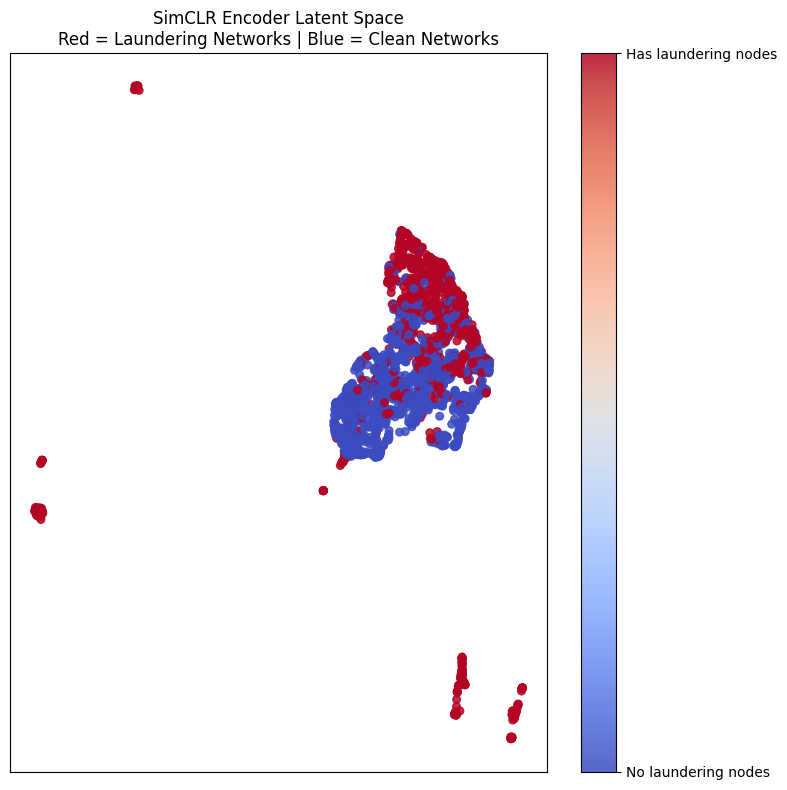

In [27]:
# ==========================================
# Visualize SimCLR Latent Space
# Colored by Laundering Presence
# ==========================================

import torch
import numpy as np
import umap
import matplotlib.pyplot as plt

from torch_geometric.data import Batch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------
# 1. Load trained encoder
# ------------------------------------------
checkpoint = torch.load("model_checkpoints/best_model_run1.pt", map_location=device)

encoder = GraphEncoder(in_dim=3, hidden_dim=64, out_dim=128).to(device)
encoder.load_state_dict(checkpoint["encoder_state_dict"])
encoder.eval()

# ------------------------------------------
# 2. Build one view per network + labels
# ------------------------------------------
full_graph = prepare_networks(networks, df_full)

graphs = []
labels = []   # 1 = laundering present, 0 = none

for net in networks:
    v = augment_network_view_fast(net, full_graph)
    graphs.append(network_to_pyg_data_fast(v))

    has_laundering = len(net["laundering_nodes"]) > 0
    labels.append(int(has_laundering))

labels = np.array(labels)

data = Batch.from_data_list(graphs).to(device)

# ------------------------------------------
# 3. Extract encoder embeddings
# ------------------------------------------
with torch.no_grad():
    h = encoder(data)

H = h.cpu().numpy()

# Normalize (important for contrastive models)
H = H / np.linalg.norm(H, axis=1, keepdims=True)

# ------------------------------------------
# 4. UMAP projection
# ------------------------------------------
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

H_2d = reducer.fit_transform(H)

# ------------------------------------------
# 5. Plot laundering vs non-laundering
# ------------------------------------------
plt.figure(figsize=(8, 8))

scatter = plt.scatter(
    H_2d[:, 0],
    H_2d[:, 1],
    c=labels,
    cmap="coolwarm",   # blue = non-laundering, red = laundering
    s=30,
    alpha=0.85
)

plt.title("SimCLR Encoder Latent Space\nRed = Laundering Networks | Blue = Clean Networks")
plt.xticks([])
plt.yticks([])

cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(["No laundering nodes", "Has laundering nodes"])

plt.tight_layout()
plt.show()
